# Prepare 

In [ ]:
#| default_exp datasets

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [ ]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

# Hugging Face Datasets 

Load a dataset builder from the Hugging Face Hub, or a local dataset. A dataset builder can be used to inspect general information that is required to build a dataset (cache directory, config, dataset info, etc.)
without downloading the dataset itself.

In [ ]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

We can get the information about the train/test splits

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, dataset_name='fashion_mnist')}

In [ ]:
dsd = load_dataset(name)
dsd

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Save x,y to variables for ease of using

In [ ]:
x,y = ds_builder.info.features

In [ ]:
x,y

('image', 'label')

In [ ]:
img = train[x][0]
img

In [ ]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

Target variable is stored as ints. We can lookup the corresponding titles in a `train.features` using `int2str`

In [ ]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

Using `int2str` is similar to the following comprehension:

In [ ]:
[featy.names[o] for o in yb]

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
TF.to_tensor?

Signature: TF.to_tensor(pic) -> torch.Tensor
Docstring:
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
This function does not support torchscript.

See :class:`~torchvision.transforms.ToTensor` for more details.

Args:
    pic (PIL Image or numpy.ndarray): Image to be converted to tensor.

Returns:
    Tensor: Converted image.
File:      /usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py
Type:      function


We can understand what is going on with collate fn and why do we need it by setting trace.

`Train` is a list of dictionaries, each dictionary consists of `x` and `y`. A batch is a slice of a list and also contains list of dictionaries. PyTorch works with tuples , so we use a coolate_fn to:
* convert PIL image to a tensor and 
* stack xs and ys in separate tensors


In [ ]:
def collate_fn(b):
#     import ipdb; ipdb.set_trace()
    return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
            # o[y] are integers, so we just convert a list of ints to a tensor
            y: tensor([o[y] for o in b])}

In [ ]:
t = [{'image': np.array([[1,6]]), 'label': 2}, {'image': np.array([[3,5]]), 'label': 4}]
collate_fn(t)

{'image': tensor([[[[1, 6]]],
 
 
         [[[3, 5]]]]),
 'label': tensor([2, 4])}

In [ ]:
dl = DataLoader(train,collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))

In [ ]:
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

Instead of writing a `collate_fn` we can skip it altogether and just use transforms. Behind the curtain, DataLoader will call `transforms` on each item when it calls `__getitem__`. Note that we need to return the changed batch du to the internals of HF.

In [ ]:
def transforms(b):
    # we can index into HuggingFace Dataset and get back a dict of all xs and ys.
    # check below
    b[x] = [TF.to_tensor(o) for o in b[x]]
    # because HF `with_transforms` requires a return value
    return b

If we don't provide custom collation function, built-in 'defualt_collate' will be used

In [ ]:
t = [{'a':1, 'b':2}, {'a':10, 'b':20}]
default_collate(t)

{'a': tensor([ 1, 10]), 'b': tensor([ 2, 20])}

In [ ]:
tds = train.with_transform(transforms) # uses default collation
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

Returning `b` in `transforms` is a bit redundant so we can rewrite it as follows.

In [ ]:
def _transforms(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [ ]:
transformi = inplace(_transforms)

In [ ]:
r = train.with_transform(transformi)[0] 
r[x].shape, r[y]

(torch.Size([1, 28, 28]), 9)

We can use a Python decorator to simplify further and avoid calling `_transforms`

In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([1, 28, 28]), 9)

In Python an `itemgetter` is a function that returns a function.

In [ ]:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

In [ ]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [ ]:
d = D()
ig(d)

(1, 3)

itemgetter works not only with dictionaries but with anything that has `__getitem__` method

In [ ]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4]) 
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [ ]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

We can now get it all together and create a function `collate_dict` that returns a function that turns a dict of tensors into a tuple of tensors:
* creates an itemgetter that will use features and labels from a dataset to separate xs and ys 
* creates an internal function that default_collates a dictionary and retturns xs and ys in a tuple
* returns that function to be called on an input batch


In [ ]:
list(tdsf.features)

['image', 'label']

In [ ]:
#|export
def collate_dict(ds):
    # import ipdb; ipdb.set_trace()
    get = itemgetter(*ds.features) # get x and y values
    def _f(b): return get(default_collate(b))
    return _f

In [ ]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

In [ ]:
cl = collate_dict(tdsf)

In [ ]:
cl

<function __main__.collate_dict.<locals>._f(b)>

## Plotting images

It is very important to be able to vizualize things.

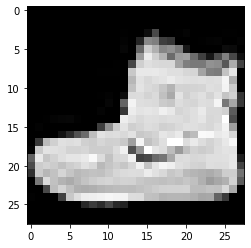

In [ ]:
b = next(iter(dl))
xb = b[x]
img = xb[0]
plt.imshow(img[0]);

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, # image-like to show
               ax=None, # axes to show image on
               figsize=None, # size of a figure
               title=None, # titile of a figure
               noframe=True, # whether to show frame
               **kwargs):
    "Show a PIL or PyTorch image on ax"
    # check if image has tensor attributes
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        # move to cpu
        im = im.detach().cpu()
        # if 3 dimensions and first dimension is less than 5: make channels last dimension:
        # (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        # (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
        if len(im.shape)==3 and im.shape[0]<5: im = im.permute(1,2,0)
    # if not tensor and not itself ndarray - cast as ndarray
    elif not isinstance(im, np.ndarray): im = np.array(im)
    # remove channels if it is 1 (greyscale image)
    if im.shape[-1]==1: im = im[...,0]
    # create ax if it is None
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    # show image
    ax.imshow(im, **kwargs)
    # add title
    if title is not None: ax.set_title(title)
    # remove xticks and yticks
    ax.set_xticks([])
    ax.set_yticks([])
    # remove axis
    if noframe: ax.axis('off')
    return ax

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on ax



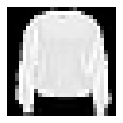

In [ ]:
show_image(img, figsize=(2,2));

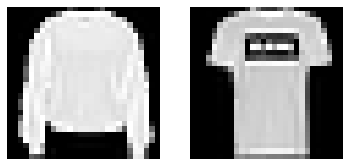

In [ ]:
fig, axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int = 1, # Number of rows in returned axes grid
    ncols:int = 1, # Number of columns in returned axes grid
    figsize:tuple = None, # (Width, height) in inches of the returned figure
    imsize:int = 3, # Size (in inches) of images that will be displayed
    suptitle:str = None, # Title to be set to returned figure
    **kwargs,
): # fig and axes
    " A figure and set of subplots to display images of `imsize` inches."
    # if figure is not given, estimate it as ncols x imsize and nrows x imsize
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    # add suptitles
    if suptitle is not None: fig.suptitle(suptitle)
    # if we have a single image, create an array of it
    if nrows*ncols==1: ax = np.array([ax])
    return fig, ax

In [ ]:
from nbdev.showdoc import *

In [ ]:
show_doc(subplots)

---

[source](https://github.com/Iamalos/fastai-p2/blob/main/miniai/datasets.py#L51){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | (Width, height) in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

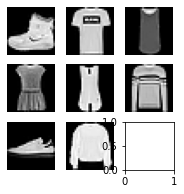

In [ ]:
fig,axs = subplots(3,3,imsize=1)
imgs=xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img,ax)

In [ ]:
#| export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int = None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int = None, # Number of cols, defaulting to `ceil(n/rows)`
    title:str = None, # If passed, title set to the figure
    weight:str = 'bold', # Title font weight
    size:int = 14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    # if rows but no cols, find the necessary ncols
    if nrows: ncols = ncols or int(np.ceil(n/nrows)) # I believe there is a mistake here in course
    # vice-versa to rows
    elif ncols: nrows = nrows or int(np.ceil(n/ncols)) 
    else:
        # if no rows and no cols, estimate rows and cols to make a square figure
        nrows = int(np.sqrt(n))
        ncols = int(np.floor(n/nrows))
    # create fig and axs
    fig, axs = subplots(nrows, ncols, **kwargs)
    # import ipdb; ipdb.set_trace()
    # remove axis for empty grid cells
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off() # if there are unused axis
    # add titles
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig, axs

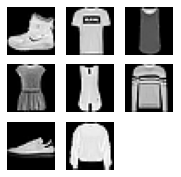

In [ ]:
fig,axs = get_grid(8,3,imsize=1)
imgs=xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img,ax)

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(ims: list, # Images to show
                nrows: int|None=None, # Number of rows in a grid
                ncols: int|None=None, # Number of columns in grid(auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs
               ):
    "Show all images `ims` as subplots with `rows` using `titles`"
    # import ipdb; ipdb.set_trace()
    # get axs from `get_grid`
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    # loop through images, titles and axes and show image
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b[y]
lbls = yb[:8]

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

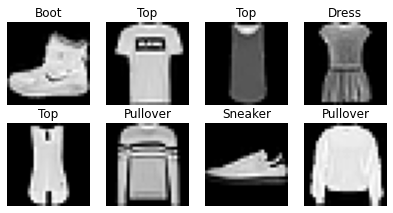

In [ ]:
show_images(imgs, imsize=1.7, titles=titles)

In [ ]:
#|export
class DataLoaders: 
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export - 

In [ ]:
import nbdev; nbdev.nbdev_export()